In [15]:
import pandas as pd
from datetime import datetime, timedelta, date
import time
import matplotlib.pyplot as plt
from typing import List


#Get the Exchange Rates
exchange_rates_csv = 'exchange_rates.csv'
exchange_rates = pd.read_csv(exchange_rates_csv ,sep=';',parse_dates=[0])
exchange_rates['Date'] = exchange_rates['Date'].apply(lambda x: x.date())
exchange_rates = exchange_rates.set_index('Date')['USD2EUR']
exchange_rates.head()

# Historical Quotes. The most updated start on 2023-08-04
# Lets use 6 months for historical data
quotes_start_date = date(2024, 3, 1)
df_quotes = pd.read_csv("ft_quotes.csv",index_col=0,parse_dates=True).sort_index(ascending=True).ffill().dropna(axis=1).loc[date(2023, 8, 4):]
df_quotes.index = [x.date() for x in df_quotes.index]


# Portofolio on Quotes Start Date
initial_amount = 100
encoding='latin_1'
thousands = ','
decimal = '.'
to_date = lambda d: datetime.strptime(d, '%d-%m-%Y').date()
transacoes_csv = 'transacoes.csv'
converters={'Data de subscricao': to_date}
df_transacoes = pd.read_csv(transacoes_csv ,sep=',',encoding=encoding,thousands=thousands, decimal=decimal, converters=converters, dtype={'Cotacao de Subscricao':float,'Quantidade':float})
df_transacoes['Data de resgate'] = df_transacoes['Data de resgate'].apply(lambda x: datetime.strptime(x, '%d-%m-%Y').date() if pd.notnull(x) else x)
df_transacoes = df_transacoes[df_transacoes['Code'].isin(df_quotes.columns)]
filter = (df_transacoes['Data de subscricao']<=quotes_start_date) & ((pd.isnull(df_transacoes['Data de resgate'])) | (df_transacoes['Data de resgate']>quotes_start_date))
df_transacoes = df_transacoes[filter]
df_transacoes['Amount'] = df_transacoes.apply(lambda x: x['Quantidade']*df_quotes[x['Code']][quotes_start_date] * (exchange_rates.loc[quotes_start_date] if x['Moeda'] == 'USD' else 1), axis=1)
df_portofolio = df_transacoes.groupby('Code')['Amount'].sum()
df_portofolio = df_portofolio * initial_amount  / df_portofolio.sum()

# Parameters
risk_free_rate = 0.03

amount_to_buy = 20
amount_to_sell = 20
final_portfolio_amount = initial_amount + amount_to_buy - amount_to_sell
transaction_amount = 2

n_funds_to_add = 5
max_weight = 0.09

In [16]:
# Select relevant funds
df_perform = pd.read_csv("ft_funds_perform.csv", index_col=0)
relevant_funds = set(df_perform[df_perform['currency'].isin(["EUR","USD"])].index)
relevant_funds &= set([idx for idx in df_perform.index if not idx.startswith("PT")])
relevant_funds &= set(df_quotes.columns)

len(relevant_funds)

3063

In [17]:
from pypfopt.expected_returns import mean_historical_return,ema_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import objective_functions

In [18]:
#Optimization parameters
transaction_limit = 1


cov_n = 153


### Portfolio Optimization Functions

In [19]:
def new_fund_performance(new_portfolio, new_fund, amount=transaction_amount, risk_free_rate=risk_free_rate, last_n=15, goal='max_sharpe',target=None,weight_bounds = (0,1)):
    if new_fund in new_portfolio.index:
        new_portfolio.loc[new_fund] += amount
    else:
        new_portfolio.loc[new_fund] = amount

    mu = mean_historical_return(df_quotes[new_portfolio.index][-last_n:])
    S = CovarianceShrinkage(df_quotes[new_portfolio.index][-cov_n:]).ledoit_wolf()
    ef = EfficientFrontier(mu, S, weight_bounds=weight_bounds, solver='SCS')
    if goal=='max_sharpe':
        ef.max_sharpe(risk_free_rate=risk_free_rate)
    elif goal=='min_volatility':
        ef.min_volatility()
    elif goal=='efficient_risk':
        ef.efficient_risk(target_volatility=target)
    elif goal=='efficient_return':
        ef.efficient_return(target_return=target)
    else:
        raise ValueError('Invalid Goal!')
    return new_portfolio, ef.portfolio_performance(risk_free_rate=risk_free_rate)

def new_funds_to_add(df_portofolio, selected_funds, n_funds_to_add, last_n, goal, target=None, verbose=False, weight_bounds = (0,1)):

    mu = mean_historical_return(df_quotes[df_portofolio.index][-last_n:])
    S = CovarianceShrinkage(df_quotes[df_portofolio.index][-cov_n:]).ledoit_wolf()

    ef = EfficientFrontier(mu, S, solver='SCS')
    weights = df_portofolio / df_portofolio.sum()
    ef.set_weights(weights)

    current_return, current_volatility, current_sharpe_ratio = ef.portfolio_performance(risk_free_rate=risk_free_rate)

    max_sharpe = current_sharpe_ratio
    min_volatility = current_volatility
    amount = transaction_amount
    funds_to_buy = []
    performance = None

    current_portfolio = df_portofolio.copy()
    for i in range(n_funds_to_add):
        best_fund = None
        for new_fund in selected_funds:
            try:
                _, (new_return,new_volatility,new_sharpe) = new_fund_performance(
                                                    new_portfolio=current_portfolio.copy(),
                                                    new_fund=new_fund,
                                                    last_n=last_n,
                                                    goal=goal,
                                                    target=target)
                if ((goal == 'max_sharpe') or (goal == 'efficient_risk')) and (new_sharpe > max_sharpe):
                    max_sharpe = new_sharpe
                    best_fund = new_fund
                if ((goal == 'min_volatility') or (goal == 'efficient_return')) and (new_volatility < min_volatility):
                    min_volatility = new_volatility
                    best_fund = new_fund
            except Exception as e:
                raise e
                pass
        
        if best_fund is None:
            print("\nNo more Funds found!")
            break
        else:
            funds_to_buy.append(best_fund)
            current_portfolio, performance = new_fund_performance(
                new_portfolio=current_portfolio,
                new_fund=best_fund,
                last_n=last_n,
                goal=goal,
                target=target)
            if verbose:
                print("### Performance with ", best_fund)
                print(df_perform.loc[best_fund][['ft category','name']])
                print(performance)
    return funds_to_buy, performance

def portfolio_strategy(dfi, ef, prev_strategy=None):
    cleaned_weights = ef.clean_weights()
    cleaned_weights = [(s,w) for s,w in cleaned_weights.items()]
    dfo = pd.DataFrame(cleaned_weights,columns=['Code','w']).sort_values(by='w',ascending=False)
    df = pd.merge(dfi,dfo,on=['Code'],how='outer',suffixes=('_i','_o')).fillna(0)
    if prev_strategy is not None:
        df['strategy'] =  df.apply(lambda x: prev_strategy.loc[x['Code']]['strategy'], axis=1)
    else:
        df['strategy'] = 'c'
    df['final_amount'] = df.apply(lambda x: x['amount'] if x['strategy']=='k' else x['w_o']*final_portfolio_amount, axis=1)
    df['change_amount'] = df['final_amount'] - df['amount']

    return df

def valid_date(d: date) -> date:
    if d in df_quotes.index:
        return d
    return max(dd for dd in df_quotes.index if dd <= d)

def next_date(current_date: date, transaction_interval: int = 7) -> date:
    return valid_date(current_date + timedelta(days=transaction_interval))

def fund_selection_1(df_portofolio: pd.Series,current_date: date) -> set:
    old_date = valid_date(current_date - timedelta(days=14))
    df_perform['2w'] = df_quotes.loc[current_date]/df_quotes.loc[old_date]
    selected_funds = set(df_perform[df_perform.groupby('ft category')['2w'].transform('max')==df_perform['2w']].index)
    selected_funds |= set(df_perform[df_perform['rating'] >= 5].index)
    selected_funds -= set(df_portofolio.index)
    return selected_funds & relevant_funds

def my_ef(df_portofolio: pd.Series, current_date: date, last_n: int):
    mu = mean_historical_return(df_quotes[df_portofolio].loc[valid_date(current_date - timedelta(days=last_n)):current_date])
    S = CovarianceShrinkage(df_quotes[df_portofolio].loc[valid_date(current_date - timedelta(days=cov_n)):current_date]).ledoit_wolf()
    return mu, S

def strategy_step(df_portofolio: pd.Series, current_date: date, fn_selection, last_n: int, new_date: date, ef_fn) -> pd.Series:
    
    mu, S = ef_fn(df_portofolio=df_portofolio.index,current_date=current_date,last_n=last_n)
    ef = EfficientFrontier(mu, S, solver='SCS')
    weights = df_portofolio / df_portofolio.sum()
    ef.set_weights(weights)
    dfi = pd.DataFrame({'w':weights, 'amount':df_portofolio}).reset_index().sort_values(by='w',ascending=False)

    new_portfolio = df_portofolio.copy()

    funds_to_buy, performance = new_funds_to_add(
        df_portofolio=new_portfolio,
        selected_funds=fn_selection(df_portofolio=new_portfolio,current_date=current_date), 
        n_funds_to_add=n_funds_to_add,
        last_n=last_n,
        goal='max_sharpe',
        verbose=False,
        weight_bounds=(0,max_weight))

    new_p = new_portfolio.index.append(pd.Index(funds_to_buy))

    mu, S = ef_fn(df_portofolio=new_p,current_date=current_date,last_n=last_n)
    ef = EfficientFrontier(mu, S, weight_bounds=(0,max_weight), solver='SCS')
    ef.max_sharpe(risk_free_rate=risk_free_rate)

    df = portfolio_strategy(dfi=dfi,ef=ef).set_index('Code')

    weight_bounds = list()
    buy_list = list()
    for i, code in enumerate(df_quotes[new_p].columns):
        if abs(df.loc[code]['change_amount']) < transaction_limit:
            weight_bounds.append((df.loc[code]['w_i'],df.loc[code]['w_i'])) # Keep
        elif df.loc[code]['change_amount'] >= 0.0:
            weight_bounds.append((df.loc[code]['w_i'],max_weight)) # keep or buy
        else:
            weight_bounds.append((0.0,df.loc[code]['w_i'])) #keep or sell
        if df.loc[code]['change_amount'] >= 0.0:
            buy_list.append((i,df.loc[code]['w_i']))

    mu, S = ef_fn(df_portofolio=new_p,current_date=current_date,last_n=last_n)
    ef = EfficientFrontier(mu, S, weight_bounds=weight_bounds, solver='SCS')
    # Limit the amount to buy
    buy_final_w = (sum([w_i for _,w_i in buy_list])*initial_amount + amount_to_buy) / final_portfolio_amount
    ef.add_constraint(lambda x : sum([x[i] for i,_ in buy_list]) == buy_final_w)
    try:
        ef.max_sharpe(risk_free_rate=risk_free_rate)
    except Exception as e:
        ef = EfficientFrontier(mu, S, weight_bounds=weight_bounds, solver='SCS')
        ef.max_sharpe(risk_free_rate=risk_free_rate)

    df = portfolio_strategy(dfi=dfi,ef=ef).set_index('Code')
    df['w_o'] = df.apply(lambda x: x['w_i'] if abs(x['change_amount'])<transaction_limit else x['w_o'], axis = 1)
    r = 1- (df['w_o'].sum()-1) / df[(df['w_o']!=df['w_i'])]['w_o'].sum()
    df['w_o'] = df.apply(lambda x: x['w_o']*(1 if x['w_o']==x['w_i'] else r) ,axis=1)

    ds = df['w_o']*df['amount'].sum()
    ds = ds[ds!=0]
    ds.name = 'amount'

    df = ds.reset_index()
    df['new_amount'] = df.apply(lambda x: x['amount']*df_quotes[x['Code']][new_date]/df_quotes[x['Code']][current_date],axis=1)
    
    return df.set_index('Code')['new_amount']

In [20]:
current_date = valid_date(d=quotes_start_date)
new_date = next_date(current_date)
value_lst = [(current_date,initial_amount)]
df_prtf = df_portofolio

while new_date < df_quotes.index.max():
    print(current_date)
    df_prtf = strategy_step(df_portofolio=df_prtf,current_date=current_date,fn_selection=fund_selection_1, last_n=21,new_date=new_date,ef_fn=my_ef)
    value_lst.append((new_date,df_prtf.sum()))
    current_date = new_date
    new_date = next_date(current_date)

results_df = pd.DataFrame(data=value_lst,columns=['date','strategy1']).set_index('date')


2024-03-01
2024-03-08
2024-03-15
2024-03-22
2024-03-29
2024-04-05
2024-04-12
2024-04-19
2024-04-26
2024-05-03


In [23]:
results_df

,strategy1
date,
2024-03-01,100.000000
2024-03-08,100.363655
2024-03-15,100.718597
2024-03-22,101.092363
2024-03-29,101.265933
2024-04-05,101.424937
2024-04-12,101.442186
2024-04-19,101.188828
2024-04-26,101.258985


In [27]:
def fund_selection_2(df_portofolio: pd.Series,current_date: date) -> set:
    old_date = valid_date(current_date - timedelta(days=14))
    df_perform['2w'] = df_quotes.loc[current_date]/df_quotes.loc[old_date]
    selected_funds = set(df_perform[df_perform.groupby('ft category')['2w'].transform('max')==df_perform['2w']].index)
    selected_funds -= set(df_perform[df_perform['2w']<0].index)
    selected_funds |= set(df_perform[df_perform['rating'] >= 5].index)
    #selected_funds -= set(df_portofolio.index)
    return selected_funds & relevant_funds



2024-03-01
2024-03-08
2024-03-15
2024-03-22
2024-03-29
2024-04-05
2024-04-12
2024-04-19
2024-04-26
2024-05-03


<Axes: xlabel='date'>

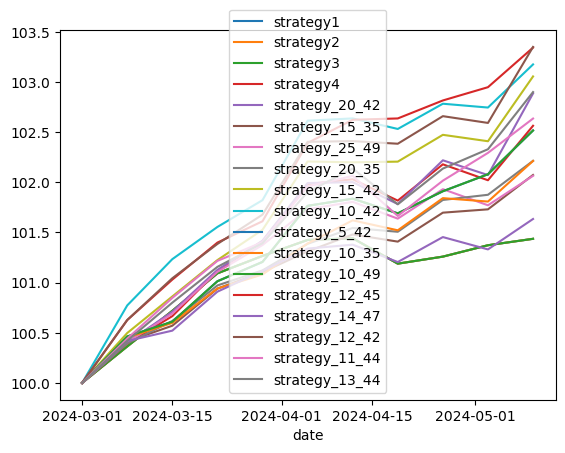

In [47]:
def my_ef_2(df_portofolio: pd.Series, current_date: date, last_n: int):
    mu = ema_historical_return(df_quotes[df_portofolio].loc[valid_date(current_date - timedelta(days=last_n)):current_date],span=13)
    S = CovarianceShrinkage(df_quotes[df_portofolio].loc[valid_date(current_date - timedelta(days=cov_n)):current_date]).ledoit_wolf()
    return mu, S

current_date = valid_date(d=quotes_start_date)
new_date = next_date(current_date)
value_lst = [(current_date,initial_amount)]
df_prtf = df_portofolio

while new_date < df_quotes.index.max():
    print(current_date)
    df_prtf = strategy_step(df_portofolio=df_prtf,current_date=current_date,fn_selection=fund_selection_1, last_n=44,new_date=new_date,ef_fn=my_ef_2)
    value_lst.append((new_date,df_prtf.sum()))
    current_date = new_date
    new_date = next_date(current_date)

results_df = results_df.join(pd.DataFrame(data=value_lst,columns=['date','strategy_13_44']).set_index('date'))
results_df.plot()

In [1]:
results_df

NameError: name 'results_df' is not defined

In [26]:
def my_ef_3(df_portofolio: pd.Series, current_date: date, last_n: int):
    mu = ema_historical_return(df_quotes[df_portofolio].loc[valid_date(current_date - timedelta(days=last_n)):current_date],span=30)
    S = CovarianceShrinkage(df_quotes[df_portofolio].loc[valid_date(current_date - timedelta(days=cov_n)):current_date]).ledoit_wolf()
    return mu, S

In [27]:
current_date = valid_date(d=quotes_start_date)
new_date = next_date(current_date)
value_lst = [(current_date,initial_amount)]
df_prtf = df_portofolio

while new_date < df_quotes.index.max():
    print(current_date)
    df_prtf = strategy_step(df_portofolio=df_prtf,current_date=current_date,fn_selection=fund_selection_1, last_n=42,new_date=new_date,ef_fn=my_ef_2)
    value_lst.append((new_date,df_prtf.sum()))
    current_date = new_date
    new_date = next_date(current_date)

results_df = results_df.join(pd.DataFrame(data=value_lst,columns=['date','strategy3']).set_index('date'))
results_df.plot()

2024-03-01
2024-03-08
2024-03-15
2024-03-22
2024-03-29
2024-04-05
2024-04-12
2024-04-19
2024-04-26


ValueError: columns overlap but no suffix specified: Index(['strategy3'], dtype='object')

In [29]:
value_lst

[(datetime.date(2024, 3, 1), 100),
 (datetime.date(2024, 3, 8), 100.38402103250768),
 (datetime.date(2024, 3, 15), 100.6969623721418),
 (datetime.date(2024, 3, 22), 101.11308312283623),
 (datetime.date(2024, 3, 29), 101.40080184034254),
 (datetime.date(2024, 4, 5), 101.73584788403276),
 (datetime.date(2024, 4, 12), 101.87430299236034),
 (datetime.date(2024, 4, 19), 101.69533334075695),
 (datetime.date(2024, 4, 26), 102.06492482195672),
 (datetime.date(2024, 5, 3), 102.11463896114442)]

In [30]:
results_df

,strategy1,strategy2,strategy3,strategy4
date,,,,
2024-03-01,100.000000,100.000000,100.000000,100.000000
2024-03-08,100.357832,100.365932,100.364173,100.432069
2024-03-15,100.758330,100.828747,100.612383,100.938200
2024-03-22,101.241804,101.242499,101.045866,101.471806
2024-03-29,101.389129,101.414236,101.363008,101.687745
2024-04-05,101.607364,101.594548,101.769199,102.034148
2024-04-12,101.543701,101.607335,102.036213,102.261133
2024-04-19,101.616737,101.746186,101.800593,102.226825
2024-04-26,101.863883,101.898631,102.236167,102.394944


In [7]:
results = []

for last_n in [18,21,25]:
    current_date = valid_date(d=quotes_start_date)
    new_date = next_date(current_date)
    value_lst = [(current_date,initial_amount)]
    df_prtf = df_portofolio

    while new_date < df_quotes.index.max():
        print(current_date)
        df_prtf = strategy_step(df_portofolio=df_prtf,current_date=current_date,fn_selection=fund_selection_1, last_n=last_n,new_date=new_date, ef_fn=my_ef)
        value_lst.append((new_date,df_prtf.sum()))
        current_date = new_date
        new_date = next_date(current_date)

    results.append(pd.DataFrame(data=value_lst,columns=['date','strategy '+str(last_n)]).set_index('date'))

results

2024-03-01


2024-03-08
2024-03-15
2024-03-22
2024-03-29
2024-04-05
2024-04-12
2024-04-19
2024-04-26
2024-03-01
2024-03-08
2024-03-15
2024-03-22
2024-03-29
2024-04-05
2024-04-12
2024-04-19
2024-04-26
2024-03-01
2024-03-08


OptimizationError: ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')

In [9]:
def my_mean_historical_return(fund_list, current_date):
    return df_quotes[fund_list].loc[current_date] / df_quotes[fund_list].loc[valid_date(current_date - timedelta(days=21))] -1

my_mean_historical_return(df_portofolio.index, valid_date(d=quotes_start_date))

IE00BLP5S460    0.006623
LU0235843108    0.000823
LU0319687124   -0.005494
LU0329070915    0.006769
LU0348927251    0.046805
LU0390137973    0.047342
LU0414665884    0.023473
LU0594300096    0.036896
LU0627762007    0.003057
LU0627762692    0.003935
LU0705071453    0.017421
LU0835721084    0.036052
LU0875418195    0.024306
LU1244139660    0.019142
LU1508158513   -0.004931
LU1728556959    0.019146
LU1883334275    0.008665
LU1897414303    0.062019
LU1915690918    0.007117
dtype: float64

In [10]:
prices = df_quotes[df_portofolio.index].loc[valid_date(current_date - timedelta(days=21)):current_date]
returns = prices.pct_change().dropna(how="all")
(1 + returns).prod() ** (252 / returns.count()) - 1

IE00BLP5S460    0.115661
LU0235843108    0.027854
LU0319687124   -0.142826
LU0329070915    0.214506
LU0348927251   -0.166190
LU0390137973   -0.103316
LU0414665884   -0.255364
LU0594300096    6.562459
LU0627762007    0.072101
LU0627762692    0.088445
LU0705071453    0.200962
LU0835721084    0.748696
LU0875418195   -0.122209
LU1244139660   -0.361817
LU1508158513    0.196743
LU1728556959    0.049171
LU1883334275    0.021744
LU1897414303    1.127333
LU1915690918   -0.098423
dtype: float64

In [11]:
current_date = valid_date(d=quotes_start_date)
new_date = next_date(current_date)
value_lst = [(current_date,initial_amount)]
df_prtf = df_portofolio

mean_historical_return(df_quotes[df_portofolio.index].loc[valid_date(current_date - timedelta(days=21)):current_date])


IE00BLP5S460    0.117274
LU0235843108    0.013919
LU0319687124   -0.088399
LU0329070915    0.120013
LU0348927251    1.156491
LU0390137973    1.175135
LU0414665884    0.476661
LU0594300096    0.838015
LU0627762007    0.052618
LU0627762692    0.068198
LU0705071453    0.336629
LU0835721084    0.813053
LU0875418195    0.496980
LU1244139660    0.375131
LU1508158513   -0.079689
LU1728556959    0.375214
LU1883334275    0.155980
LU1897414303    1.748028
LU1915690918    0.126538
dtype: float64

In [12]:
ema_historical_return(df_quotes[df_portofolio.index].loc[valid_date(current_date - timedelta(days=21)):current_date],span=120)


IE00BLP5S460    0.128157
LU0235843108    0.012119
LU0319687124   -0.093490
LU0329070915    0.106069
LU0348927251    1.182401
LU0390137973    1.155998
LU0414665884    0.488749
LU0594300096    0.758535
LU0627762007    0.044015
LU0627762692    0.059874
LU0705071453    0.344190
LU0835721084    0.796056
LU0875418195    0.525393
LU1244139660    0.499027
LU1508158513   -0.082981
LU1728556959    0.376504
LU1883334275    0.152431
LU1897414303    1.778150
LU1915690918    0.108636
Name: 2024-03-01, dtype: float64